(11250, 39) (11250, 7) training data size
(3750, 39) (3750, 7) Validation data size
Model: "Hexagonal_sensor_concept_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 39)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 700)               28000     
_________________________________________________________________
dense_4 (Dense)              (None, 700)               490700    
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 4907      
Total params: 523,607
Trainable params: 523,607
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
176/176 - 1s - loss: 0.1958 - val_loss: 0.1648
Epoch 2/30
176/176 - 1s - loss: 0.1511 - val_loss: 0.1431
Epoch 3/30
176/176 - 1s - loss:

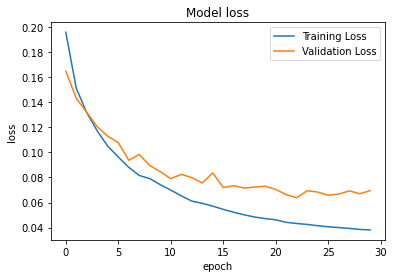

C(beta)= -0.25102253614152453


In [2]:
#                                MASTER THESIS 

# Topic: MACHINE LEARNING APPROACHES TO THE INVERSE PROBLEM OF IDENTIFYING CRACKS FROM ELECTRICAL SIGNALS IN STRUCTURAL HEALTH MONITORING"

# Programmed by: Vundurthy, Padmanabha Pavan Chandra.

# Course: M.Sc. Computational Materials Science.

# Technische Universitaet Bergakademie Freiberg, Freiberg

# Date: July 2nd, 2021

## This program computes the Neural Network model, to solve the inverse problem, using the input data (strains) and output data (crack coordinates, angle, stress intensity factors and T stress) obtained from generated training data.

#Import numpy, math, matplotlib, tensorflow, keras and pandas modules
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import pandas as pd

#Reading the Training data (virtually generated) from a file 
#Input data
x_data = pd.read_csv('x_hex_data_5_lat.csv')
x_data=x_data.values[:,1:]

#Output data
y_data = pd.read_csv('y_hex_data_5_lat.csv')
y_data=y_data.values[:,1:]

#Import MinMaxScaler from scikit-learn module to normalize/scale the data
from sklearn.preprocessing import MinMaxScaler
#Import train_test_split from scikit-learn module to extract validation data from training dataset
from sklearn.model_selection import train_test_split

#Using the imported modules, distribute input and output data into training and validation datasets for input(X_train, X_val) and output (y_train, y_val) respectively.
X_train, X_val, y_train, y_val = train_test_split(x_data, y_data)
print(np.shape(X_train), np.shape(y_train), "training data size")
print(np.shape(X_val), np.shape(y_val),"Validation data size")

#Scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(X_train)
xtrain_scale=scaler_x.transform(X_train)
scaler_x.fit(X_val)
xval_scale=scaler_x.transform(X_val)
scaler_y.fit(y_train)
ytrain_scale=scaler_y.transform(y_train)
scaler_y.fit(y_val)
yval_scale=scaler_y.transform(y_val)

#Import specific features from keras and tensorflow modules to build the model architecture. 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense
from numpy import loadtxt
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

#Model architecture with an Input layer, 2 hidden layers with 700 units in each and an output layer is built.
#ReLU is used as activation function for hidden layers and 'linear' is used as activation function for output layer.
input_layer = Input(shape=(39,)) #for hexagon with 13 sensors = 39, for 4x4 rectangle = 48....
hidden_layer_1 = Dense(units = 700, activation = 'relu')(input_layer)
hidden_layer_2 = Dense(units = 700, activation = 'relu')(hidden_layer_1)
output_layer = Dense(units = 7, activation = 'linear')(hidden_layer_2)
model = Model(inputs = input_layer, outputs = output_layer, name = 'Hexagonal_sensor_concept_NN')

#Compile The model
#Loss function is MAE and adam is used as optimizer 
model.compile(loss='mae', optimizer="adam")
#opt = keras.optimizers.Adam(learning_rate=0.0001):can be used in place of optimizer for specific learning rates

#Learning rate scheduler for 10 epochs 
def scheduler(epoch, lr):
    if epoch < 10:    #change 10 to 5 for lr scheduler for 5 epochs
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
#The Learning rate scheduler is invoked using a callback function('specific feature of keras')
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

##To implement early stopping-which stops the model at an epoch where the parameter being monitored doesnot improve any further, providing desired fit for a certain 'patience'.
##Implementing Early stopping and other features
#my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)]
#    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
#    tf.keras.callbacks.CSVLogger('Points_5_training.log')]

# Display the model
model.summary()

#Fit the model using parameters in the following sequence
#The training data is provided as input and output
#number of epochs[can be varied for hyperparameter tuning for 10,20,30..n epochs]
#Batch size[can be varied to 32,128,256,512]
#Verbose: displays the results while computation for each epoch
#The validation data is provided
#The callback functions holding learning rate scheduler are invoked

#Creating a Callback subclass that stores each epoch prediction
class prediction_history(tf.keras.callbacks.Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self, epoch, logs={}):
        self.predhis.append(model.predict(xval_scale))

#Calling the subclass
predictions=prediction_history()

history = model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=64, verbose=2, validation_data=(xval_scale,yval_scale), callbacks=[callback, predictions])

#The model is fit and can be used for comparing training loss and validation loss in the model over epochs for specific hyperparameters.

#To plot training loss vs. validation loss of a model using 'history' feature of keras:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

#the model is fit and saved in 'model' variable, to test it a specific keras feature called evaluate can be used
#prediction error in sin(beta) and cos(beta)
check_data=predictions.predhis
np.shape(check_data)
err_sincos_mean=[]

for i in range(0,30):
    err_sincos = (check_data[i][:][2]**2+check_data[i][:][3]**2)-1
    err_sincos_mean.append(np.mean(err_sincos))
asd = np.array(history.history['val_loss'])
#to print the constant C(beta)
print('C(beta)=',np.mean(asd/err_sincos_mean))
